In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
raw_data = pd.read_csv("/content/drive/MyDrive/Google Colab Notebooks/Mini Sem 8/dataset/large sample/IBM_2years_15Min (1).csv")

In [4]:
print(raw_data.shape)
raw_data.head()

(21541, 7)


,Unnamed: 0,time,open,high,low,close,volume
0,0,2022-03-25 19:30:00,131.300,131.30,131.300,131.30,1000
1,1,2022-03-25 18:00:00,131.300,131.30,131.300,131.30,100
2,2,2022-03-25 17:00:00,131.340,131.35,131.340,131.35,1427
3,3,2022-03-25 16:45:00,131.326,131.35,131.326,131.35,1326
4,4,2022-03-25 16:15:00,131.350,131.40,131.350,131.40,56109


In [5]:
open_ds = raw_data.loc[:, ['time', 'open']]
high_ds = raw_data.loc[:, ['time', 'high']]
low_ds = raw_data.loc[:, ['time', 'low']]
close_ds = raw_data.loc[:, ['time', 'close']]
volume_ds = raw_data.loc[:, ['time', 'volume']]

In [6]:
# reversing the dataframe 
close_ds_rev = close_ds.loc[::-1, :]
close_ds_rev = close_ds_rev.reset_index(drop=True)
close_ds_rev.head()

,time,close
0,2020-04-06 07:15:00,94.703037
1,2020-04-06 07:30:00,95.557695
2,2020-04-06 07:45:00,95.013822
3,2020-04-06 08:00:00,95.177847
4,2020-04-06 08:15:00,94.746202


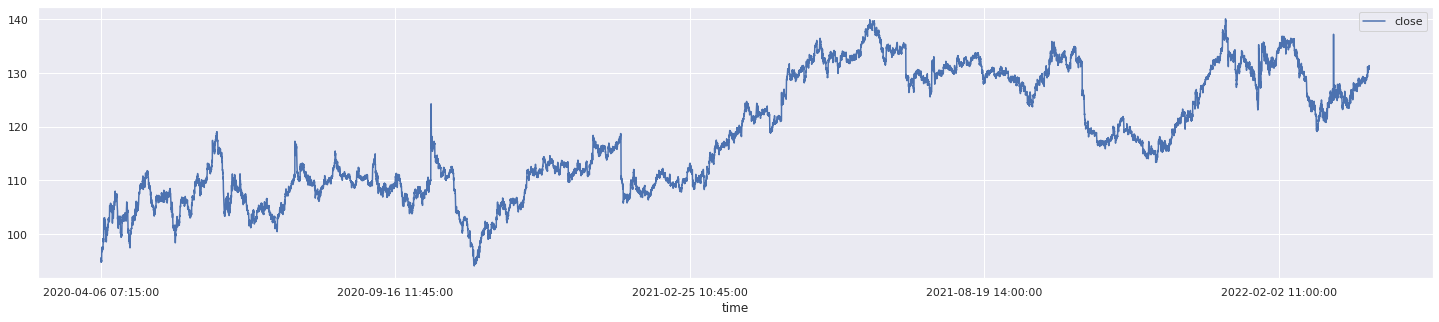

In [7]:
close_ds_rev.plot(x='time', y='close', figsize=(25, 5))

In [8]:
# converting time serires into a supervised learning problem
# split a univariate sequence into samples
def split_sequence(sequence, n_in, n_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_in
		out_end_ix = end_ix + n_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [9]:
# sequence ---> time series sequence we need to convert 
# n_in ---> number of previous data points (lag observations) to consider as input
# n_out --> number of datapoints to predict [It will be a tensor of (1, n_out) dimension]
# dataset ----> dataframe with (n_in + n_out + 1 [for current timestamp]) numbers of columns used for supervised training of the model 

n_in = 50
n_out = 5
features, target = split_sequence(close_ds_rev.drop('time', axis=1).to_numpy().flatten(), n_in, n_out)
print(f'feature shape{features.shape}')
print(f'target shape{target.shape}')
print(features[0])
print(target[0])

feature shape(21487, 50)
target shape(21487, 5)
[ 94.70303705  95.55769527  95.01382185  95.17784717  94.7462016
  95.02245476  94.96202438  94.96202438  94.96202438  94.87569527
  96.08430285  97.50010031  97.31725525  97.05982183  96.63680918
  96.77493576  97.37060664  97.17204968  97.31017626  97.04255601
  97.16341677  97.21521424  96.90442943  97.08572057  97.12456867
  97.29722689  97.52599904  97.56484714  97.12025221  97.35334082
  97.5691636   97.77635347  97.83678385  97.82815094  98.06987246
  99.07129017  98.63101169  99.06257093  98.9266889   99.06265726
  99.12308764  98.68280916  98.45835346  98.91589776  99.12308764
 102.90430279 102.04101166 101.98921419 102.73164456 102.29136609]
[102.59351798 101.87698634 102.299999   101.98058128 102.77480912]


In [10]:
# train test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=0, shuffle=False)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(15040, 50)
(15040, 5)
(6447, 50)
(6447, 5)


In [11]:
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_test_series.shape)

Train set shape (15040, 50, 1)
Validation set shape (6447, 50, 1)


In [18]:
# Model training

from tensorflow import keras 
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout

# CNN

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(5))
model_cnn.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.0003))
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 49, 64)            192       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 24, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1536)              0         
                                                                 
 dense_2 (Dense)             (None, 50)                76850     
                                                                 
 dense_3 (Dense)             (None, 5)                 255       
                                                                 
Total params: 77,297
Trainable params: 77,297
Non-trainable params: 0
__________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [19]:
cnn_history = model_cnn.fit(X_train_series, y_train, validation_data=(X_test_series, y_test), epochs=35, verbose=2)

Epoch 1/35
470/470 - 3s - loss: 421.0751 - val_loss: 1.4312 - 3s/epoch - 7ms/step
Epoch 2/35
470/470 - 2s - loss: 1.6844 - val_loss: 1.4168 - 2s/epoch - 5ms/step
Epoch 3/35
470/470 - 2s - loss: 1.6846 - val_loss: 1.4117 - 2s/epoch - 5ms/step
Epoch 4/35
470/470 - 2s - loss: 1.6507 - val_loss: 1.3788 - 2s/epoch - 5ms/step
Epoch 5/35
470/470 - 2s - loss: 1.6141 - val_loss: 1.4420 - 2s/epoch - 5ms/step
Epoch 6/35
470/470 - 2s - loss: 1.5738 - val_loss: 1.3093 - 2s/epoch - 5ms/step
Epoch 7/35
470/470 - 2s - loss: 1.5322 - val_loss: 1.4151 - 2s/epoch - 5ms/step
Epoch 8/35
470/470 - 2s - loss: 1.5099 - val_loss: 1.1981 - 2s/epoch - 5ms/step
Epoch 9/35
470/470 - 2s - loss: 1.4216 - val_loss: 1.2010 - 2s/epoch - 5ms/step
Epoch 10/35
470/470 - 2s - loss: 1.3491 - val_loss: 1.2588 - 2s/epoch - 5ms/step
Epoch 11/35
470/470 - 3s - loss: 1.2697 - val_loss: 1.0734 - 3s/epoch - 5ms/step
Epoch 12/35
470/470 - 3s - loss: 1.2445 - val_loss: 1.5781 - 3s/epoch - 5ms/step
Epoch 13/35
470/470 - 2s - loss: 1.

Text(0, 0.5, 'MSE')

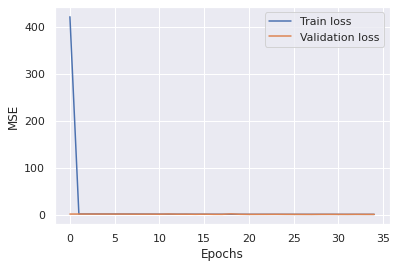

In [20]:
# plots 
fig = plt.figure()
plt.plot(cnn_history.history['loss'], label='Train loss')
plt.plot(cnn_history.history['val_loss'], label='Validation loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('MSE')

In [21]:
# separate values

from sklearn.metrics import mean_squared_error

def split_matrix(data, dimension):
    output = []
    for _ in range(0, dimension):
        output.append([])
    
    for i in range(0, len(data)):
        for j in range(0, dimension):
            output[j].append(data[i, j])
    
    return data

# calculate RMSE 

def calculate_RMSE(actual, predicted, n_out):
    actual_values = split_matrix(actual, n_out)
    predicted_values = split_matrix(predicted, n_out)

    RMSE_vector = []
    for i in range(0, n_out):
        RMSE_val = np.sqrt(actual_values[i], predicted_values[i])
        RMSE_vector.append(RMSE_val)
    
    return RMSE_vector

def printRMSE(data):
    for i in range(0, len(data)):
        print(f'RMSE for prection{i+1} = {data[i]}')

In [23]:
# RMSE calculation
cnn_train_pred = model_cnn.predict(X_train)
cnn_test_pred = model_cnn.predict(X_test)
train_RMSE_values = calculate_RMSE(y_train, cnn_train_pred, n_out)
test_RMSE_values = calculate_RMSE(y_test, cnn_test_pred, n_out)

print("Train RMSE values --- ")
printRMSE(train_RMSE_values)
print()
print("Test RMSE values --- ")
printRMSE(test_RMSE_values)

Train RMSE values --- 
RMSE for prection1 = [10.128846  10.093413  10.1143465 10.098543  10.137791 ]
RMSE for prection2 = [10.093413  10.1143465 10.098543  10.137791  10.110504 ]
RMSE for prection3 = [10.1143465 10.098543  10.137791  10.110504  10.134384 ]
RMSE for prection4 = [10.098543 10.137791 10.110504 10.134384 10.11648 ]
RMSE for prection5 = [10.137791 10.110504 10.134384 10.11648  10.150131]

Test RMSE values --- 
RMSE for prection1 = [11.417344  11.415712  11.421016  11.407314  11.4206085]
RMSE for prection2 = [11.415712  11.421016  11.407314  11.4206085 11.4147   ]
RMSE for prection3 = [11.421016  11.407314  11.4206085 11.4147    11.414488 ]
RMSE for prection4 = [11.407314  11.4206085 11.4147    11.414488  11.412447 ]
RMSE for prection5 = [11.4206085 11.4147    11.414488  11.412447  11.407959 ]


In [24]:
print(cnn_test_pred[0])
print(y_test[0])

[11.417344  11.415712  11.421016  11.407314  11.4206085]
[130.35574938 130.31847826 130.43960941 130.12681152 130.43029163]


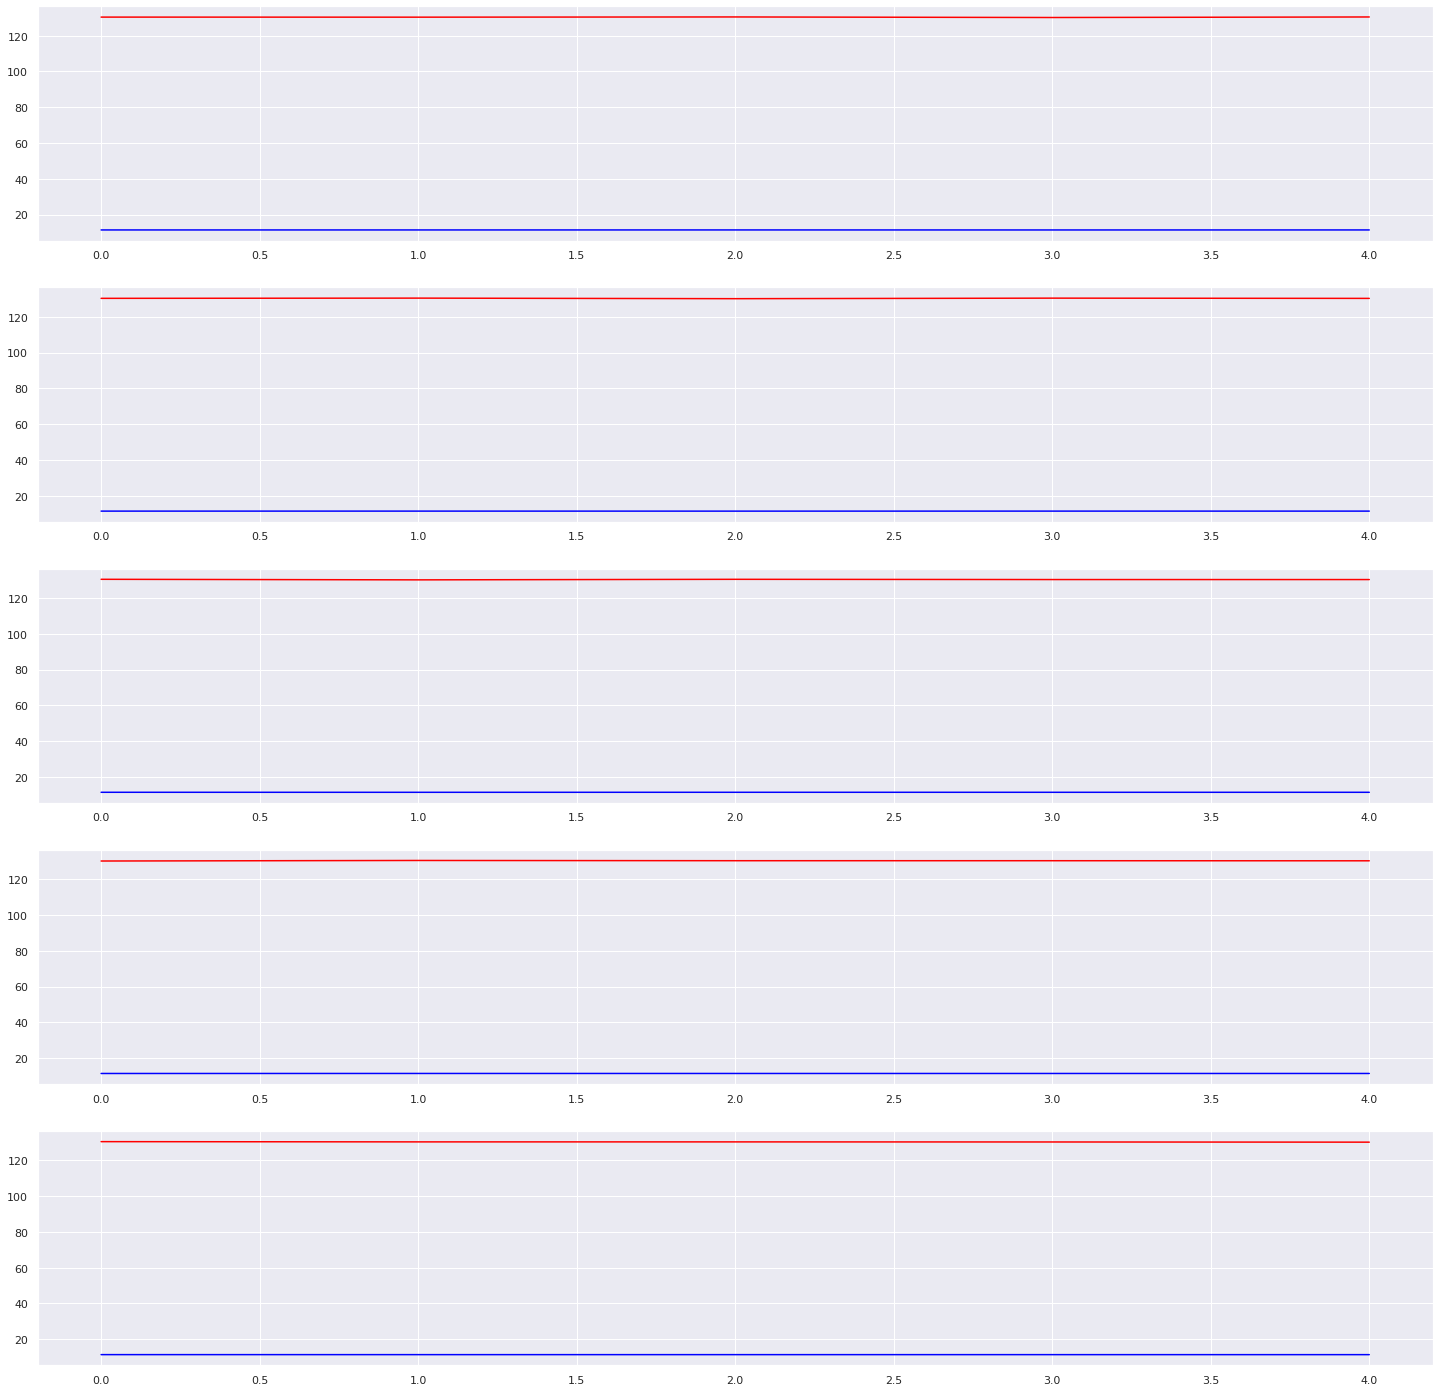

In [ ]:
fig, axs = plt.subplots(n_out, figsize=(25, 25))
actual = split_matrix(y_test, n_out)
predicted = split_matrix(mlp_test_pred, n_out)
for i in range(0, n_out):
    axs[i].plot(pd.Series(actual[i]), color='red')
    axs[i].plot(pd.Series(predicted[i]), color='blue')
